## Conjoint Survey Data Statistical Modeling to price a golf ball product

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import pyrsm as rsm
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

from sklearn.linear_model import LogisticRegression

import pyreadr
# increase plot resolution
mpl.rcParams["figure.dpi"] = 70

## Goal

For a particular profile of product attributes (Brand, Compression, Spin, SoftCore tech), using customer preference data on varying profiles, tease out price of ball that maximizes profit

In [3]:
from IPython.display import HTML

HTML('''

<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()">
  <input type="submit" id="toggleButton" value="Show Python 3 Code">
</form>''')

## The data

Courtesy Professor Kanishka Misra, Rady School of Management, UC San Diego

In [2]:
choicedata = pd.read_csv("https://www.dropbox.com/s/eje66bvgvpxd421/rawdata_choice.csv?dl=1")
profiledata = pd.read_csv("https://www.dropbox.com/s/veivd844co1ei86/rawdata_profiles.csv?dl=1")
predictprofiledata = pd.read_csv("https://www.dropbox.com/s/dh7tzbj4g54uho0/rawdata_profiles_predict.csv?dl=1")

Choice data <br>
100 customers presented with 3 out of 18 product profiles at a time, and customer elects one option. <br>
Exercise repeated 50 times with each customer. <br>
100 customers x 3 product configurations x 50 trials = 15000 rows

In [3]:
choicedata

,respondent,repetitions,option_1,option_2,option_3,choice
0,1,1,14,5,17,14
1,1,2,17,14,10,14
2,1,3,1,3,7,3
3,1,4,2,18,16,16
4,1,5,17,12,14,17
...,...,...,...,...,...,...
4995,100,46,11,9,14,9
4996,100,47,16,13,9,9
4997,100,48,7,1,10,1
4998,100,49,14,11,17,11


Profile data
Attributes that make up a product profile

In [4]:
profiledata

,Product,Brand,Compression,Spin,SoftCore,Price
0,P1,TVel,100,High,No,29
1,P2,TV1,100,High,No,29
2,P3,Cal,80,High,Yes,34
3,P4,TV1,100,High,Yes,34
4,P5,TV1,60,High,No,39
5,P6,TVel,100,Low,Yes,39
6,P7,Cal,80,High,No,39
7,P8,Cal,100,High,No,34
8,P9,TV1,80,Low,No,34
9,P10,TVel,60,High,No,34


Profile data for prediction <br>

5 profiles <br>
Desired profile of the new product to be priced along with 3 pricing levels (Callaway product) - i.e. 3 profiles <br>
Two close competitors that along with the new product represents ~100% of market share

In [5]:
predictprofiledata

,Product,Brand,Compression,Spin,SoftCore,Price
0,Comp1,TVel,60,Low,No,29
1,Comp2,TV1,80,High,No,39
2,Cal29,Cal,100,High,Yes,29
3,Cal34,Cal,100,High,Yes,34
4,Cal39,Cal,100,High,Yes,39


### Methodology

Perform logistic regression for each customer (50 data points) using their picks from profile options <br>
Identify each customers utility value/preference for the 5 attributes (i.e. coefficients of the regression model) <br>
Predict likelihood of selection of the 5 new profiles for each of the 100 customers <br>
Calculate market share for the 3 pricing levels as: <br>
exp(mean_pred_coef_profile_n) / [ exp(mean_pred_coef_profile_n) + exp(mean_pred_coef_competitor1) + exp(mean_pred_coef_competitor2)] <br>
Estimate profit_per_unit as market_share*(price - cost), pick pricing level that yields max. profit

## Value to stakeholder

Traditional surveys that ask for a willingness to pay only can get a stated preference but never a revealed preference (which is the price that customer actually pays) <br>
Conjoint analysis and user utility analysis teases out a price that the customer is comfortable with <br>
Caveat is that the attribute levels of any new product must be varied and tested in the survey experiment, e.g., cannot determine if $42 is an optimal price, if that never was a pricing level tested in the experiment

In [6]:
n = 3
temp1 = choicedata['respondent'].repeat(n).reset_index(drop = True)
temp2 = choicedata['repetitions'].repeat(n).reset_index(drop = True)
temp3 = "P" + choicedata[['option_1', 'option_2', 'option_3']].stack().reset_index(drop = True).astype(str)
temp4 = pd.Series(rsm.ifelse(temp3 == "P" + choicedata['choice'].repeat(n).reset_index(drop = True).astype(str), 1, 0))

In [7]:
df = pd.concat([temp1, temp2, temp3, temp4], axis = 1).rename(columns = {0: 'product', 1: 'choice_yes'})
df = df.merge(profiledata, left_on='product', right_on='Product', how='left').drop(['product'], axis = 1)
df

,respondent,repetitions,choice_yes,Product,Brand,Compression,Spin,SoftCore,Price
0,1,1,1,P14,Cal,60,High,No,29
1,1,1,0,P5,TV1,60,High,No,39
2,1,1,0,P17,TVel,60,Low,No,34
3,1,2,0,P17,TVel,60,Low,No,34
4,1,2,1,P14,Cal,60,High,No,29
...,...,...,...,...,...,...,...,...,...
14995,100,49,1,P11,TV1,80,Low,No,29
14996,100,49,0,P17,TVel,60,Low,No,34
14997,100,50,1,P18,TV1,60,High,Yes,39
14998,100,50,0,P5,TV1,60,High,No,39


In [8]:
#Check how many NAs in each column:
df.isna().apply(sum)

respondent     0
repetitions    0
choice_yes     0
Product        0
Brand          0
Compression    0
Spin           0
SoftCore       0
Price          0
dtype: int64

### Variation of the attribute levels against response (choice_yes)

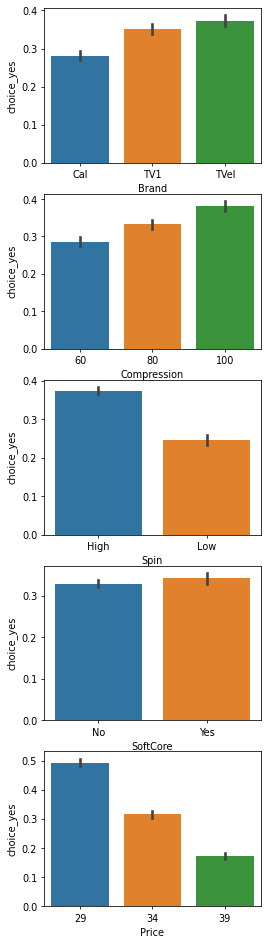

In [9]:
i = ['Brand', 'Compression', 'Spin', 'SoftCore', 'Price']

fig, axes = plt.subplots(5, figsize=(4, 17))
sns.barplot(data = df, x = i[0], y = 'choice_yes', ax = axes[0])
axes[0].set_xlabel(i[0])
sns.barplot(data = df, x = i[1], y = 'choice_yes', ax = axes[1])
axes[1].set_xlabel(i[1])
sns.barplot(data = df, x = i[2], y = 'choice_yes', ax = axes[2])
axes[2].set_xlabel(i[2])
sns.barplot(data = df, x = i[3], y = 'choice_yes', ax = axes[3])
axes[3].set_xlabel(i[3])
sns.barplot(data = df, x = i[4], y = 'choice_yes', ax = axes[4])
axes[4].set_xlabel(i[4])
plt.show()

In [10]:
df[['Product', 'Brand', 'Compression', 'Spin', 'SoftCore', "Price"]] = df[['Product', 'Brand', 'Compression', 'Spin', 'SoftCore', "Price"]].astype('category')
df['Brand'] = df['Brand'].cat.reorder_categories(["Cal", "TV1", "TVel"])
df['Spin'] = df['Spin'].cat.reorder_categories(["High", "Low"])
#df['Price'].cat.categories

df.dtypes

respondent        int64
repetitions       int64
choice_yes        int64
Product        category
Brand          category
Compression    category
Spin           category
SoftCore       category
Price          category
dtype: object

In [11]:
evar = ['Brand', 'Compression', 'Spin', 'SoftCore', 'Price']
rvar = 'choice_yes'

X = pd.get_dummies(df[evar], drop_first=True)
y = df[rvar]

#y = df['Product'] # this is incorrect

attribute = [item.split("_")[0] for item in X.columns.to_list()]

y

0        1
1        0
2        0
3        0
4        1
        ..
14995    1
14996    0
14997    1
14998    0
14999    0
Name: choice_yes, Length: 15000, dtype: int64

In [12]:
def findest(df = df):
    evar = ['Brand', 'Compression', 'Spin', 'SoftCore', 'Price']
    rvar = 'choice_yes'

    X = pd.get_dummies(df[evar], drop_first=True)
    y = df[rvar]

    clf = LogisticRegression(multi_class='multinomial',solver ='newton-cg', penalty = 'none', fit_intercept = False).fit(X,y)

    intercept = clf.intercept_
    coef = clf.coef_[0]

    attribute = [item.split("_")[0] for item in X.columns.to_list()]

    return intercept, coef, clf

In [13]:
intercept, coef, *_ = findest(df)

print("Intercept: ", intercept.round(4))
print("Coefficients: ", coef.round(4))

Intercept:  [0.]
Coefficients:  [ 0.1265  0.1424  0.0535  0.1101 -0.3505  0.0179 -0.436  -0.8309]


### Importance Weights - across the customers, which attributes do customers value the most?

In [14]:
iw_df = pd.concat([pd.Series(X.columns), pd.Series(coef), pd.Series(attribute)], axis = 1).rename(columns = {0: 'factor', 1: 'coefficient', 2: 'attribute'})
iw_df = iw_df.assign(range_iw = iw_df.groupby('attribute')['coefficient'].transform(lambda grp: np.max(grp.to_list() + [0]) - np.min(grp.to_list() + [0])))
range_total = iw_df.groupby('attribute')['range_iw'].mean().sum()
iw_df = iw_df.assign(attribute_iw = iw_df.groupby('attribute')['range_iw'].transform(lambda x: x.mean() / range_total))
iw_df

,factor,coefficient,attribute,range_iw,attribute_iw
0,Brand_TV1,0.126504,Brand,0.142427,0.098107
1,Brand_TVel,0.142427,Brand,0.142427,0.098107
2,Compression_80,0.053524,Compression,0.110101,0.075840
3,Compression_100,0.110101,Compression,0.110101,0.075840
4,Spin_Low,-0.350460,Spin,0.350460,0.241405
5,SoftCore_Yes,0.017887,SoftCore,0.017887,0.012321
6,Price_34,-0.436022,Price,0.830878,0.572327
7,Price_39,-0.830878,Price,0.830878,0.572327


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Brand'),
  Text(1, 0, 'Compression'),
  Text(2, 0, 'Price'),
  Text(3, 0, 'SoftCore'),
  Text(4, 0, 'Spin')])

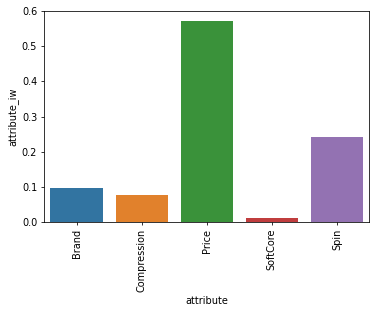

In [15]:
y = iw_df.groupby('attribute')['attribute_iw'].mean()

sns.barplot(data = iw_df, y = y, x = y.index)
plt.xticks(rotation=90)

In [16]:
# Individual customer regressions
X

,Brand_TV1,Brand_TVel,Compression_80,Compression_100,Spin_Low,SoftCore_Yes,Price_34,Price_39
0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1
2,0,1,0,0,1,0,1,0
3,0,1,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
14995,1,0,1,0,1,0,0,0
14996,0,1,0,0,1,0,1,0
14997,1,0,0,0,0,1,0,1
14998,1,0,0,0,0,0,0,1


In [17]:
result = df.groupby('respondent').apply(findest)

In [18]:
customer_pw = result[0:100].apply(pd.Series)[1].apply(pd.Series)
customer_pw.columns = X.columns
customer_pw

,Brand_TV1,Brand_TVel,Compression_80,Compression_100,Spin_Low,SoftCore_Yes,Price_34,Price_39
respondent,,,,,,,,
1,-0.841169,0.111403,0.813943,0.323437,0.194127,-0.843625,-0.181269,-1.992854
2,-0.273730,0.351211,-0.092613,0.109378,-0.375579,0.075224,-0.780453,-0.195750
3,0.054891,0.234959,-0.231453,0.123573,-0.798568,0.277011,0.076536,-0.908728
4,0.411948,0.503218,0.205683,-0.609544,-1.022134,-0.066695,0.227821,-1.165872
5,1.508455,1.694159,-0.199597,-0.259715,-1.064350,0.122342,-1.440385,-2.550668
...,...,...,...,...,...,...,...,...
96,-0.695705,-0.542894,0.400643,0.027274,-0.193561,0.127439,-0.157390,0.050251
97,0.472244,0.233747,-0.574411,-0.166603,-1.378822,0.198017,0.303156,-1.100967
98,0.305562,0.203911,0.343052,0.689282,0.000833,-0.158725,-0.844218,-1.824180


## Distribution of part-worths - across the customers, how do the attribute levels impact choice? <br>
0: no impact <br>
-: negative impact <br>
+: positive impact or preference

<AxesSubplot:xlabel='Price_39', ylabel='Count'>

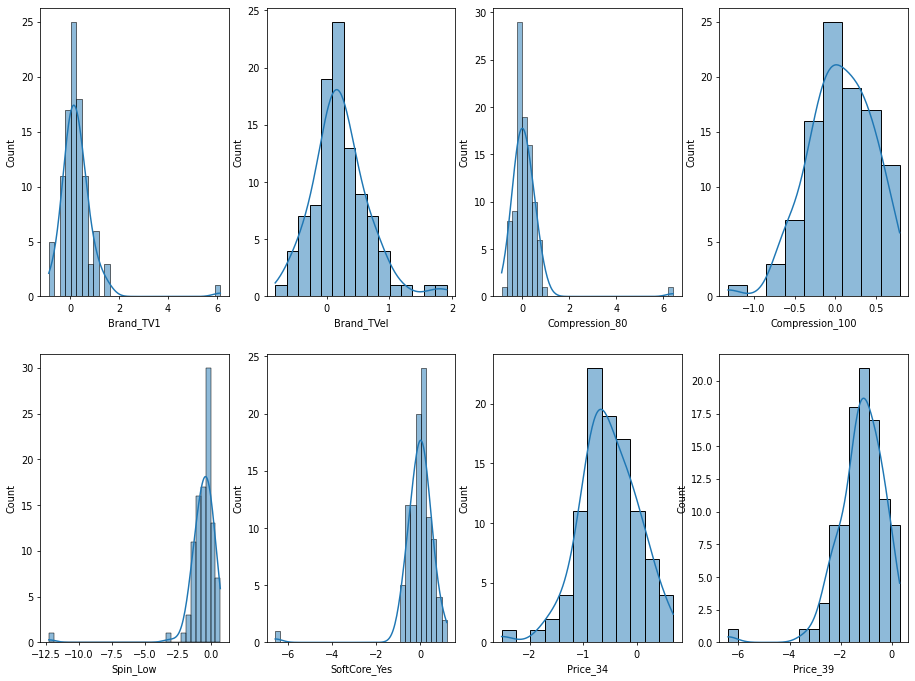

In [30]:
fig, axes = plt.subplots(ncols = 4, nrows = 2, figsize=(16, 12))
sns.histplot(data = customer_pw, x = customer_pw.columns[0], ax = axes[0, 0], kde = True)
sns.histplot(data = customer_pw, x = customer_pw.columns[1], ax = axes[0, 1], kde = True)
sns.histplot(data = customer_pw, x = customer_pw.columns[2], ax = axes[0, 2], kde = True)
sns.histplot(data = customer_pw, x = customer_pw.columns[3], ax = axes[0, 3], kde = True)

sns.histplot(data = customer_pw, x = customer_pw.columns[4], ax = axes[1, 0], kde = True)
sns.histplot(data = customer_pw, x = customer_pw.columns[5], ax = axes[1, 1], kde = True)
sns.histplot(data = customer_pw, x = customer_pw.columns[6], ax = axes[1, 2], kde = True)
sns.histplot(data = customer_pw, x = customer_pw.columns[7], ax = axes[1, 3], kde = True)

### Predicted utilities for 100 customers

In [20]:
customer_pw_T = customer_pw.T.reset_index()
field = customer_pw_T.pop("index")
customer_pw_T = pd.concat([pd.Series(attribute), pd.Series(field), customer_pw_T], axis = 1).rename(columns = {0: 'attribute', 'index': 'factor'})
customer_pw_T

,attribute,factor,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,100
0,Brand,Brand_TV1,-0.841169,-0.273730,0.054891,0.411948,1.508455,0.341742,-0.063408,0.475166,...,0.596856,0.404201,1.056864,0.057226,0.691466,-0.695705,0.472244,0.305562,0.422636,0.737613
1,Brand,Brand_TVel,0.111403,0.351211,0.234959,0.503218,1.694159,0.687018,-0.417864,0.037513,...,0.409202,0.212224,0.920154,-0.247875,0.275377,-0.542894,0.233747,0.203911,0.849451,0.080852
2,Compression,Compression_80,0.813943,-0.092613,-0.231453,0.205683,-0.199597,-0.197160,-0.065852,0.102909,...,-0.166147,0.685643,-0.106731,-0.024431,-0.107637,0.400643,-0.574411,0.343052,-0.077324,-0.644073
3,Compression,Compression_100,0.323437,0.109378,0.123573,-0.609544,-0.259715,0.200805,0.157863,0.695462,...,0.199878,-0.059023,-0.002670,-0.123984,-0.267213,0.027274,-0.166603,0.689282,0.451526,0.322639
4,Spin,Spin_Low,0.194127,-0.375579,-0.798568,-1.022134,-1.064350,0.126694,-0.750173,-0.507673,...,0.196700,-0.146960,-0.348609,-0.364506,-1.552193,-0.193561,-1.378822,0.000833,-0.841823,0.724506
5,SoftCore,SoftCore_Yes,-0.843625,0.075224,0.277011,-0.066695,0.122342,0.687945,-0.401186,0.066740,...,0.075823,-0.275424,0.509933,0.298288,0.092431,0.127439,0.198017,-0.158725,0.316803,-0.465923
6,Price,Price_34,-0.181269,-0.780453,0.076536,0.227821,-1.440385,-1.196981,0.266093,-1.026967,...,-1.011833,-1.007344,-1.662444,0.199870,-0.077629,-0.157390,0.303156,-0.844218,-1.117285,-0.681338
7,Price,Price_39,-1.992854,-0.195750,-0.908728,-1.165872,-2.550668,-2.454220,0.123038,-1.368286,...,-2.421658,-1.594124,-2.931002,-1.000509,-2.219351,0.050251,-1.100967,-1.824180,-1.350660,-1.279029


In [21]:
# Importance weights for each customer
iw_customer = pd.DataFrame()
for i in range(1,101):
    att_df = customer_pw_T.groupby('attribute')[i].apply(lambda grp: np.max(grp.to_list() + [0]) - np.min(grp.to_list() + [0]))
    iw_customer = pd.concat([iw_customer, att_df / att_df.sum()], axis = 1)

iw_customer.T

,Brand,Compression,Price,SoftCore,Spin
1,0.198572,0.169673,0.415427,0.175861,0.040467
2,0.303637,0.098140,0.379194,0.036549,0.182480
3,0.088636,0.133930,0.371682,0.104500,0.301252
4,0.132392,0.214479,0.366668,0.017547,0.268914
5,0.297679,0.045634,0.448175,0.021497,0.187016
...,...,...,...,...,...
96,0.428129,0.246551,0.127780,0.078425,0.119115
97,0.117251,0.142618,0.348624,0.049165,0.342342
98,0.102586,0.231413,0.612432,0.053289,0.000280
99,0.218503,0.136036,0.347429,0.081491,0.216541


### Distribution of importance-weights - distributed across the customers, which attributes do they value the most?

Higher the importance weight,more important that attribute is to the customer

<AxesSubplot:xlabel='Spin', ylabel='Count'>

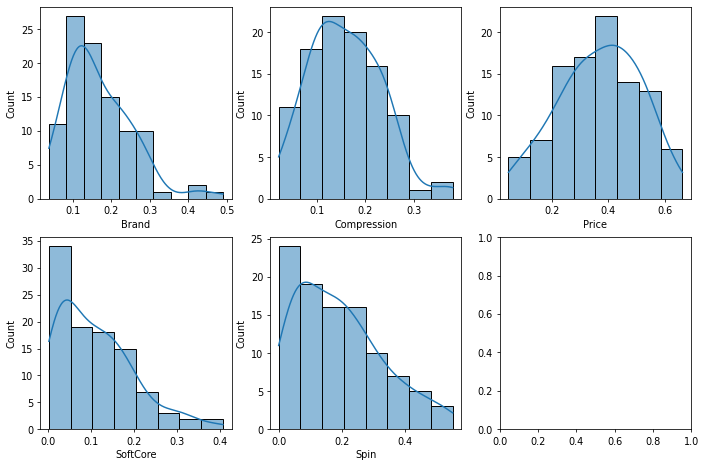

In [22]:
fig, axes = plt.subplots(ncols = 3, nrows = 2, figsize=(12, 8))

sns.histplot(data = iw_customer.T, x = iw_customer.T.columns[0], ax = axes[0, 0], kde = True)
sns.histplot(data = iw_customer.T, x = iw_customer.T.columns[1], ax = axes[0, 1], kde = True)

sns.histplot(data = iw_customer.T, x = iw_customer.T.columns[2], ax = axes[0, 2], kde = True)
sns.histplot(data = iw_customer.T, x = iw_customer.T.columns[3], ax = axes[1, 0], kde = True)

sns.histplot(data = iw_customer.T, x = iw_customer.T.columns[4], ax = axes[1, 1], kde = True)

### Predicted Utils - 5 products across all customers

In [23]:
predictprofiledata

,Product,Brand,Compression,Spin,SoftCore,Price
0,Comp1,TVel,60,Low,No,29
1,Comp2,TV1,80,High,No,39
2,Cal29,Cal,100,High,Yes,29
3,Cal34,Cal,100,High,Yes,34
4,Cal39,Cal,100,High,Yes,39


In [24]:
predictprofiledata[['Product', 'Brand', 'Compression', 'Spin', 'SoftCore', "Price"]] = predictprofiledata[['Product', 'Brand', 'Compression', 'Spin', 'SoftCore', "Price"]].astype('category')

X_predictprofile = pd.get_dummies(predictprofiledata[evar], drop_first=True)
X_predictprofile

,Brand_TV1,Brand_TVel,Compression_80,Compression_100,Spin_Low,SoftCore_Yes,Price_34,Price_39
0,0,1,0,0,1,0,0,0
1,1,0,1,0,0,0,0,1
2,0,0,0,1,0,1,0,0
3,0,0,0,1,0,1,1,0
4,0,0,0,1,0,1,0,1


In [25]:
X

,Brand_TV1,Brand_TVel,Compression_80,Compression_100,Spin_Low,SoftCore_Yes,Price_34,Price_39
0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1
2,0,1,0,0,1,0,1,0
3,0,1,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
14995,1,0,1,0,1,0,0,0
14996,0,1,0,0,1,0,1,0
14997,1,0,0,0,0,1,0,1
14998,1,0,0,0,0,0,0,1


In [26]:
predicted_utils = pd.DataFrame()

for i in range(5):
    temp = customer_pw.rmul(X_predictprofile.iloc[i, :], axis = 1).sum(axis = 1)
    name = predictprofiledata['Product'][i]
    predicted_utils[name] = temp

In [27]:
predicted_utils

,Comp1,Comp2,Cal29,Cal34,Cal39
respondent,,,,,
1,0.305530,-2.020080,-0.520187,-0.701456,-2.513041
2,-0.024368,-0.562094,0.184603,-0.595850,-0.011147
3,-0.563609,-1.085290,0.400584,0.477120,-0.508144
4,-0.518915,-0.548242,-0.676239,-0.448418,-1.842111
5,0.629810,-1.241811,-0.137373,-1.577758,-2.688041
...,...,...,...,...,...
96,-0.736455,-0.244810,0.154713,-0.002677,0.204964
97,-1.145075,-1.203134,0.031414,0.334570,-1.069553
98,0.204744,-1.175566,0.530557,-0.313662,-1.293624


In [28]:
predicted_utils['sharepred29'] = np.exp(predicted_utils.Cal29) / (np.exp(predicted_utils.Cal29) + np.exp(predicted_utils.Comp1) + np.exp(predicted_utils.Comp2))
predicted_utils['sharepred34'] = np.exp(predicted_utils.Cal34) / (np.exp(predicted_utils.Cal34) + np.exp(predicted_utils.Comp1) + np.exp(predicted_utils.Comp2))
predicted_utils['sharepred39'] = np.exp(predicted_utils.Cal39) / (np.exp(predicted_utils.Cal39) + np.exp(predicted_utils.Comp1) + np.exp(predicted_utils.Comp2))

In [29]:
result_df = pd.DataFrame()

result_df['price'] = [29, 34, 39]
result_df['share'] = [predicted_utils['sharepred29'].mean(), predicted_utils['sharepred34'].mean(), predicted_utils['sharepred39'].mean()]
result_df['revenue'] = result_df['price'] * result_df['share']
result_df['profit'] = (result_df['price'] - 18) * result_df['share']
result_df

,price,share,revenue,profit
0,29,0.455395,13.206446,5.009342
1,34,0.352625,11.989267,5.642008
2,39,0.248626,9.696412,5.221145


Pricing level of $34 is most optimal